# Test Bias Simulation   
I Analyzed the Unbias trajectory performing the Deep-TICA Analysis, in order to find the slow modes of the system.  
Using a lag time $\tau = 1$ I obtained a first Deep-TICA able to distinguish the two basins inside the lowest basin A, but the second Deep-TICA is  noisy in the $\phi$-$\psi$ plane.  
Then I performed a simulation with these CVs, but after $100$ $ns$ a transition between basin A and B never happened. (I performed the simulation biasing initially both, and then only the first one).    

------------------------------------------------
  
One can obtain few transitions biasing along the CVs obtained from the analysis of unbias trajectory with a lag time $\tau=10$. Biasing both (`Bias.ipynb`) few transitions occured.  
At first it seems that the transions happend due to the second Deep-TICA, which is possible. But in `Different_seeds_Unbias.ipnyb` I evaluate these 2 CVs for different seeds, and not always the obtained CVs are similar. Especially the second one, indicating that it comes from noise.  
Biasing just along the first CV only one transition occurs.  

------------------------------------------------

In this jupyter I analyze different simulation biasing along CVs trained with different lag times and seeds. In particular I will focus my self on the two lag times for which the gap between eigenvalues is maximum: $\tau = 4$ and $\tau = 10$   

## Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import integrate

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- reading multiple files from the same folder --#
import glob

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

## prepare data and files

In [3]:
# lag time to analyse
lag = 10
# load benchmark dataset
data_complete = load_dataframe("angles/COLVAR")
descriptors_names = data_complete.filter(regex='^d[^a-z]').columns.values
X_complete = data_complete[descriptors_names].to_numpy()
#load files
hist_files = sorted( glob.glob("test_different_seeds/lag"+str(lag)+"/bias1_seed*/COLVAR") )

#-- prepare colors for plotting --#
cmap = plt.get_cmap('fessa')
color = [cmap(i) for i in np.linspace(0, 1, len(hist_files))]
alpha = [i for i in np.linspace(1,.1,len(hist_files))]

## trajectories in $\psi$ and $\phi$ space 

Text(0, 0.5, '$\\psi$')

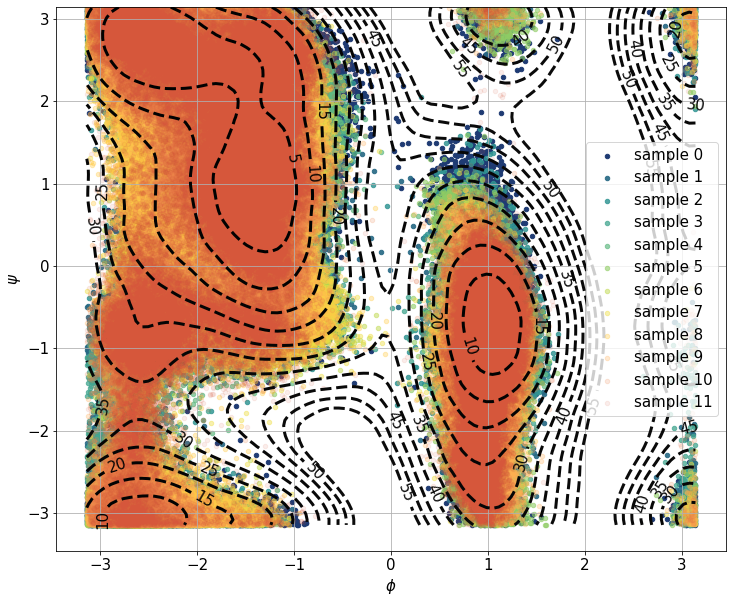

In [4]:
# trajectories 
fig,ax = plt.subplots(1,1,figsize=(12,10))
for i, file in enumerate(hist_files):
    load_dataframe(file).plot.scatter(y="psi",x="phi",ax=ax,label="sample "+str(i),color=color[i],alpha=alpha[i])
# plot fes isolines
fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")
    

## Histograms, Mean and Standard deviation

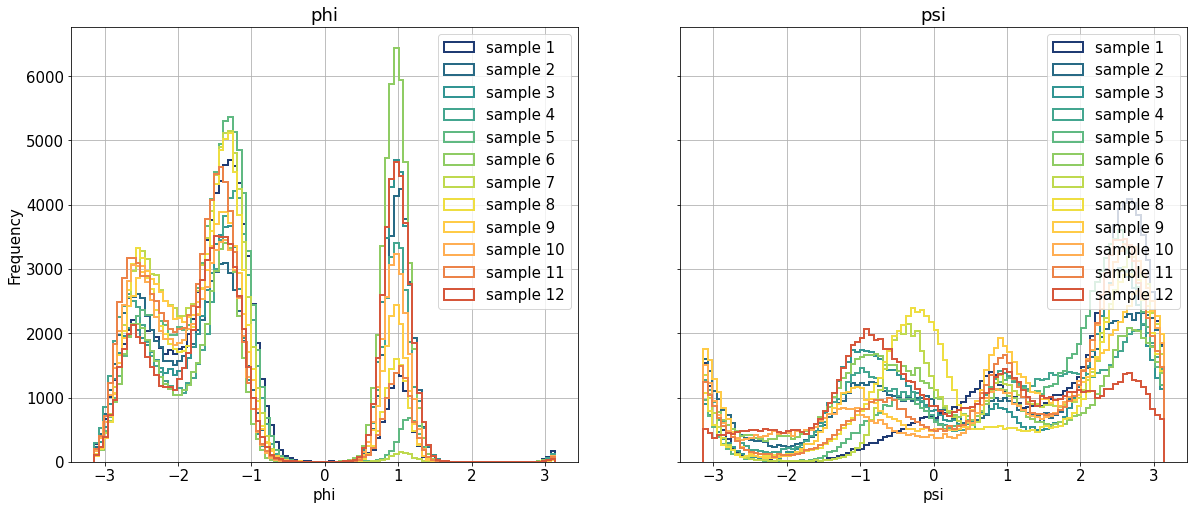

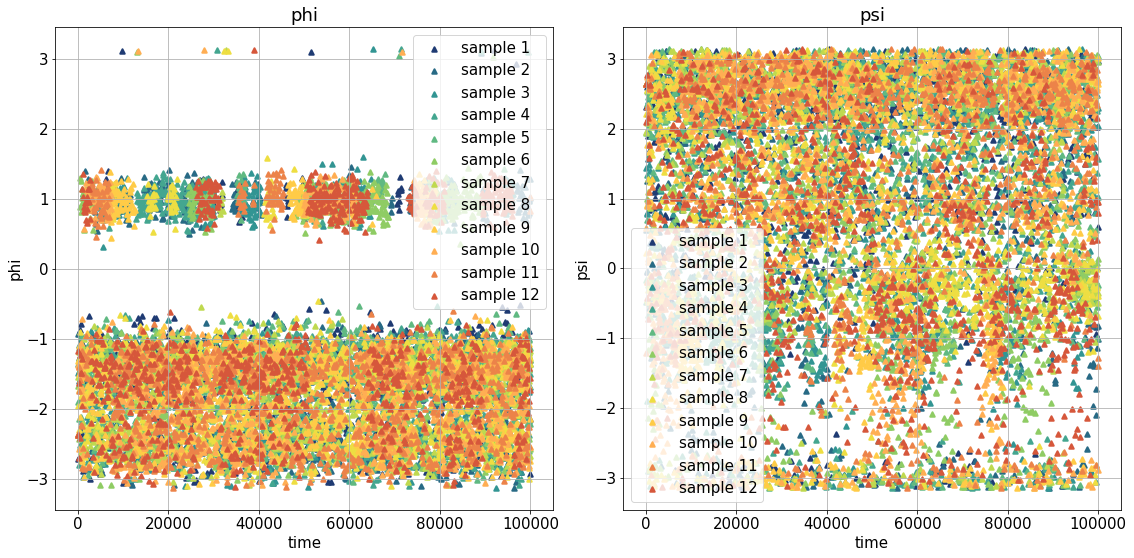

In [5]:
fig1,axs1 = plt.subplots(1,2,figsize=(20,8),sharey=True)
fig2,axs2 = plt.subplots(1,2,figsize=(16,8))#,sharey=True)
k=0
# bins for histograms
bins = 100
for file in hist_files:
    data = load_dataframe(file)
    descriptors_names = data.filter(regex='^p').columns.values

    # histograms
    for ax,desc in zip(axs1.flatten(),descriptors_names):
        data[desc].plot.hist(bins=bins,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=False,color=color[k],label="sample "+str(k+1))
        #data[desc].plot.hist(bins=50,alpha=alpha[k],ax=ax,grid=True,color=color[k],density=True,label="sample "+str(k+1))
        ax.set_title(desc)
        ax.set_xlabel(desc)
        ax.legend()

    # scatter plot
    for ax,desc in zip(axs2.flatten(),descriptors_names):
        data[::100].plot.scatter(x="time",y=desc,alpha=1,ax=ax,grid=True,linewidth=2,marker="^",label="sample "+str(k+1),color=color[k])
        #data[::100].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color=color[k])
        ax.set_title(desc)
        ax.set_ylabel(desc)
        ax.legend()
    k+=1

    plt.tight_layout()

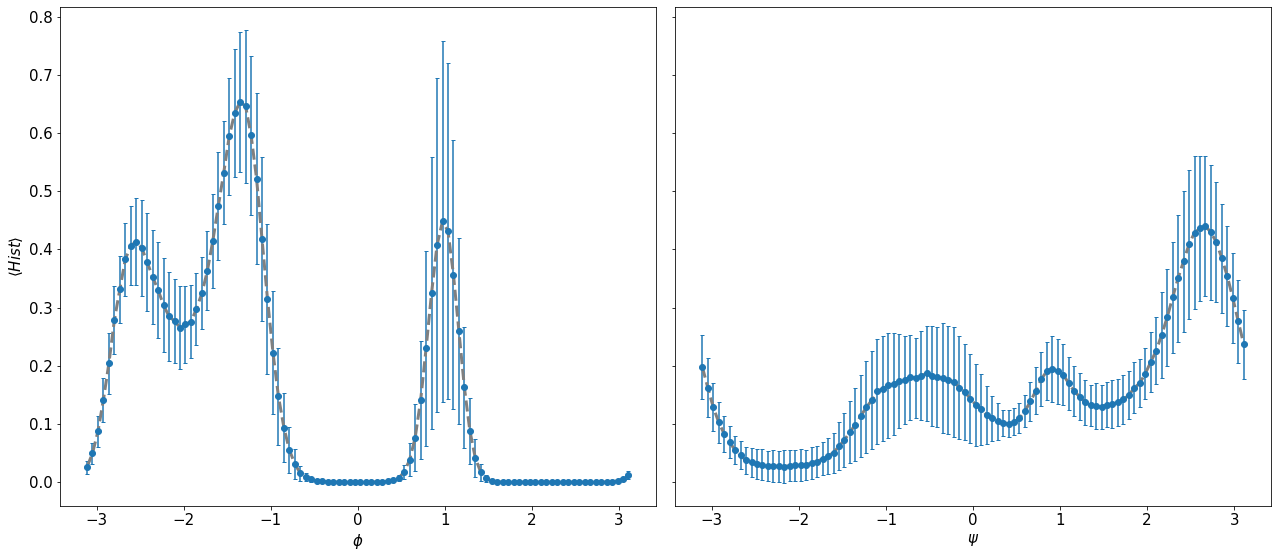

In [6]:
# edges to plot histograms
edges = np.histogram(load_dataframe(hist_files[0]),bins=bins,range=(-np.pi,np.pi))[1]
x = (edges[:-1]+edges[1:])/2

# axes for plot
fig, axs = plt.subplots(1,2,figsize=(18,8),sharey=True)
# angles
descriptors_names = data_complete.filter(regex='^p').columns.values

for j,ax in enumerate(axs):
    #-- faster way using pandas --#
    df = pd.concat( ( pd.Series(np.histogram(load_dataframe(file)[descriptors_names[j]],bins=bins,range=(-np.pi,np.pi),density=True)[0]) for file in hist_files),ignore_index=True,axis='columns')
    df2 = pd.concat( (df.mean(axis=1),df.std(axis=1)), ignore_index=True,axis='columns') 
    df2.columns = ["mean","std"]
    df2[descriptors_names[j]] = x
    ax.errorbar(df2[descriptors_names[j]], df2["mean"], df2["std"], fmt='o', capsize=2, capthick=1)
    ax.plot(x,df2["mean"].to_numpy(),color="gray",linewidth=3,linestyle="dashed")
axs[0].set_xlabel(r"$\phi$")
axs[1].set_xlabel(r"$\psi$")
axs[0].set_ylabel(r"$\langle Hist \rangle$")
plt.tight_layout()

## Estimation of the Free Energy

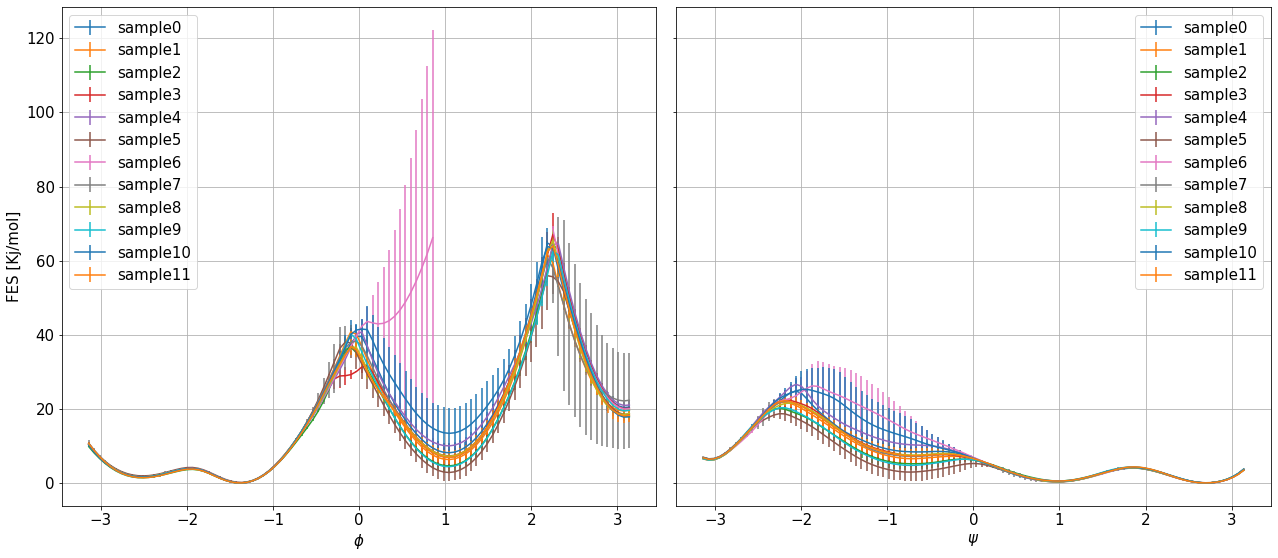

In [7]:
#-- estimation of Free Energy Surface --#
fig, axs = plt.subplots(1,2,figsize=(18,8),sharey=True)
samples = ["sample"+str(i) for i in range(len(hist_files))]
for file in hist_files:
    s = load_dataframe(file).filter(regex="^p").to_numpy()
    logweight = np.transpose( load_dataframe(file).filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
    logweight = logweight - np.max(logweight)

    for i in range(2):
        fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            temp=sim_parameters["temp"],
                                            kbt=sim_parameters["kbt"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = axs[i])

for i in range(2):
    axs[i].legend(samples)   
    axs[i].grid()
    axs[i].set_ylabel("")
axs[0].set_ylabel("FES [Kj/mol]")
axs[0].set_xlabel(r"$\phi$")
axs[1].set_xlabel(r"$\psi$")
plt.tight_layout()

## different trainings  
Are the new cvs able to distinguish the TS ?

In [8]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':5,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':500,
              #if reweight the timescale
              "reweighting": False,
              }
#--------------------------------------#
models = []
datas = []

In [9]:
torch.manual_seed(21)
for i,file in enumerate(hist_files):
    model,data,logweight,X = training(sim_parameters["beta"],file,train_parameters)
    #-- move the model back to cpu for convenience --# 
    model.to('cpu')
    # append model
    models.append(model)
    # save cvs values and append dataframe
    data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
    data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
    datas.append(data)

no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
402   -1.636      -1.652      0.972  0.661  
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
252   -1.090      -1.076      0.981  0.107  
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
363   -1.166      -1.173      0.987  0.176  
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
351   -1.076      -1.053      0.991  0.083  
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
355   -1.048      -1.023      0.988  0.060  
no weights
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.991      -1.984      0.998  0.994  
INFO: Early stopping
983   -1.998      -1.989      1.000  0.998  
no weights
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.951      -1.955      0.997  0.954  
INFO: Early stopping
618   -1.955      -1.954      0

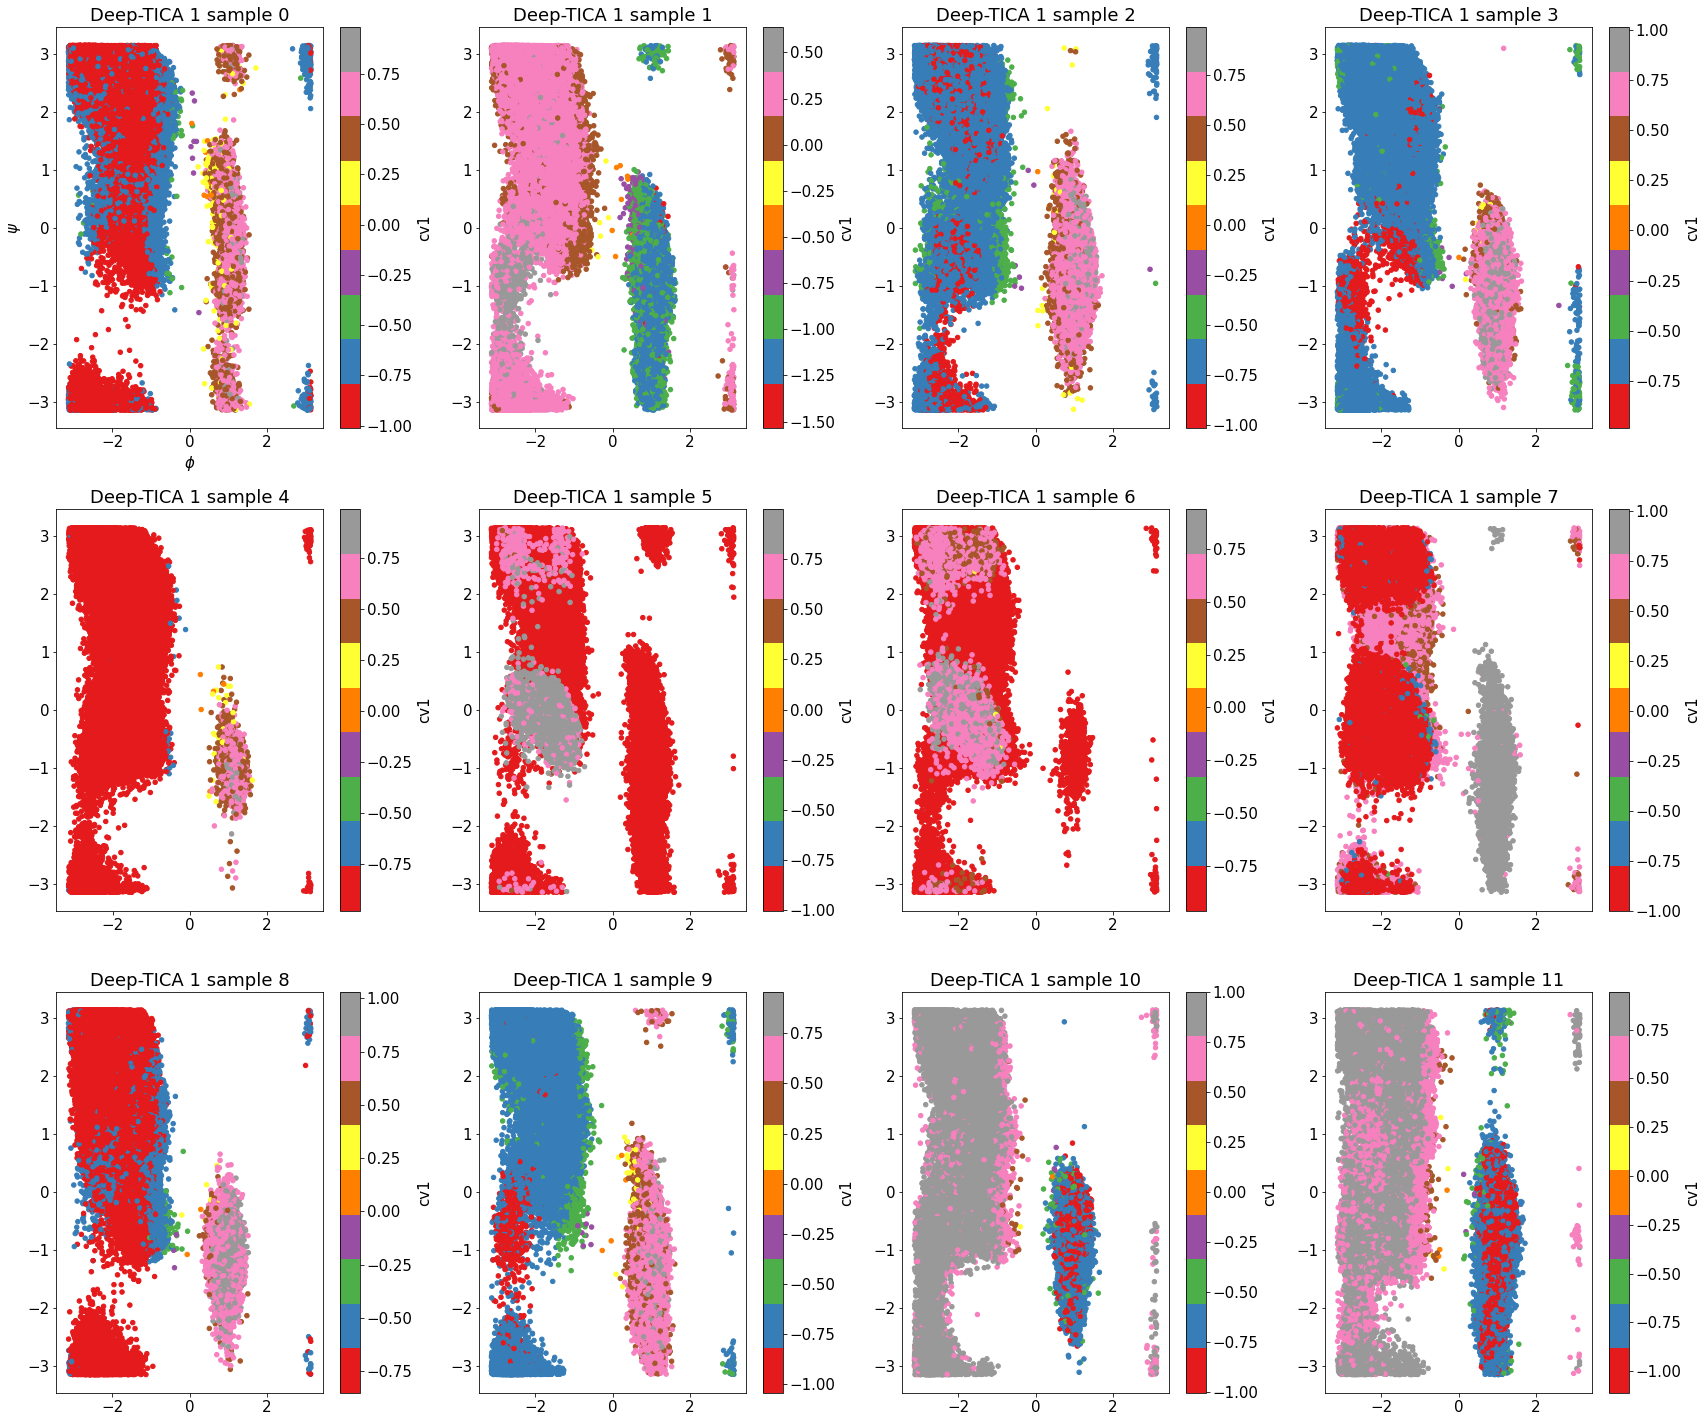

In [10]:
#-- cv1 --#
fig,axs = plt.subplots(3,4,figsize=(24,20))

for i,ax in enumerate(fig.axes):
    datas[i].plot.scatter(y="psi",x="phi",c="cv1",cmap="Set1",ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title('Deep-TICA 1 sample '+str(i))
axs[0][0].set_ylabel(r"$\psi$")
axs[0][0].set_xlabel(r"$\phi$")
plt.tight_layout()

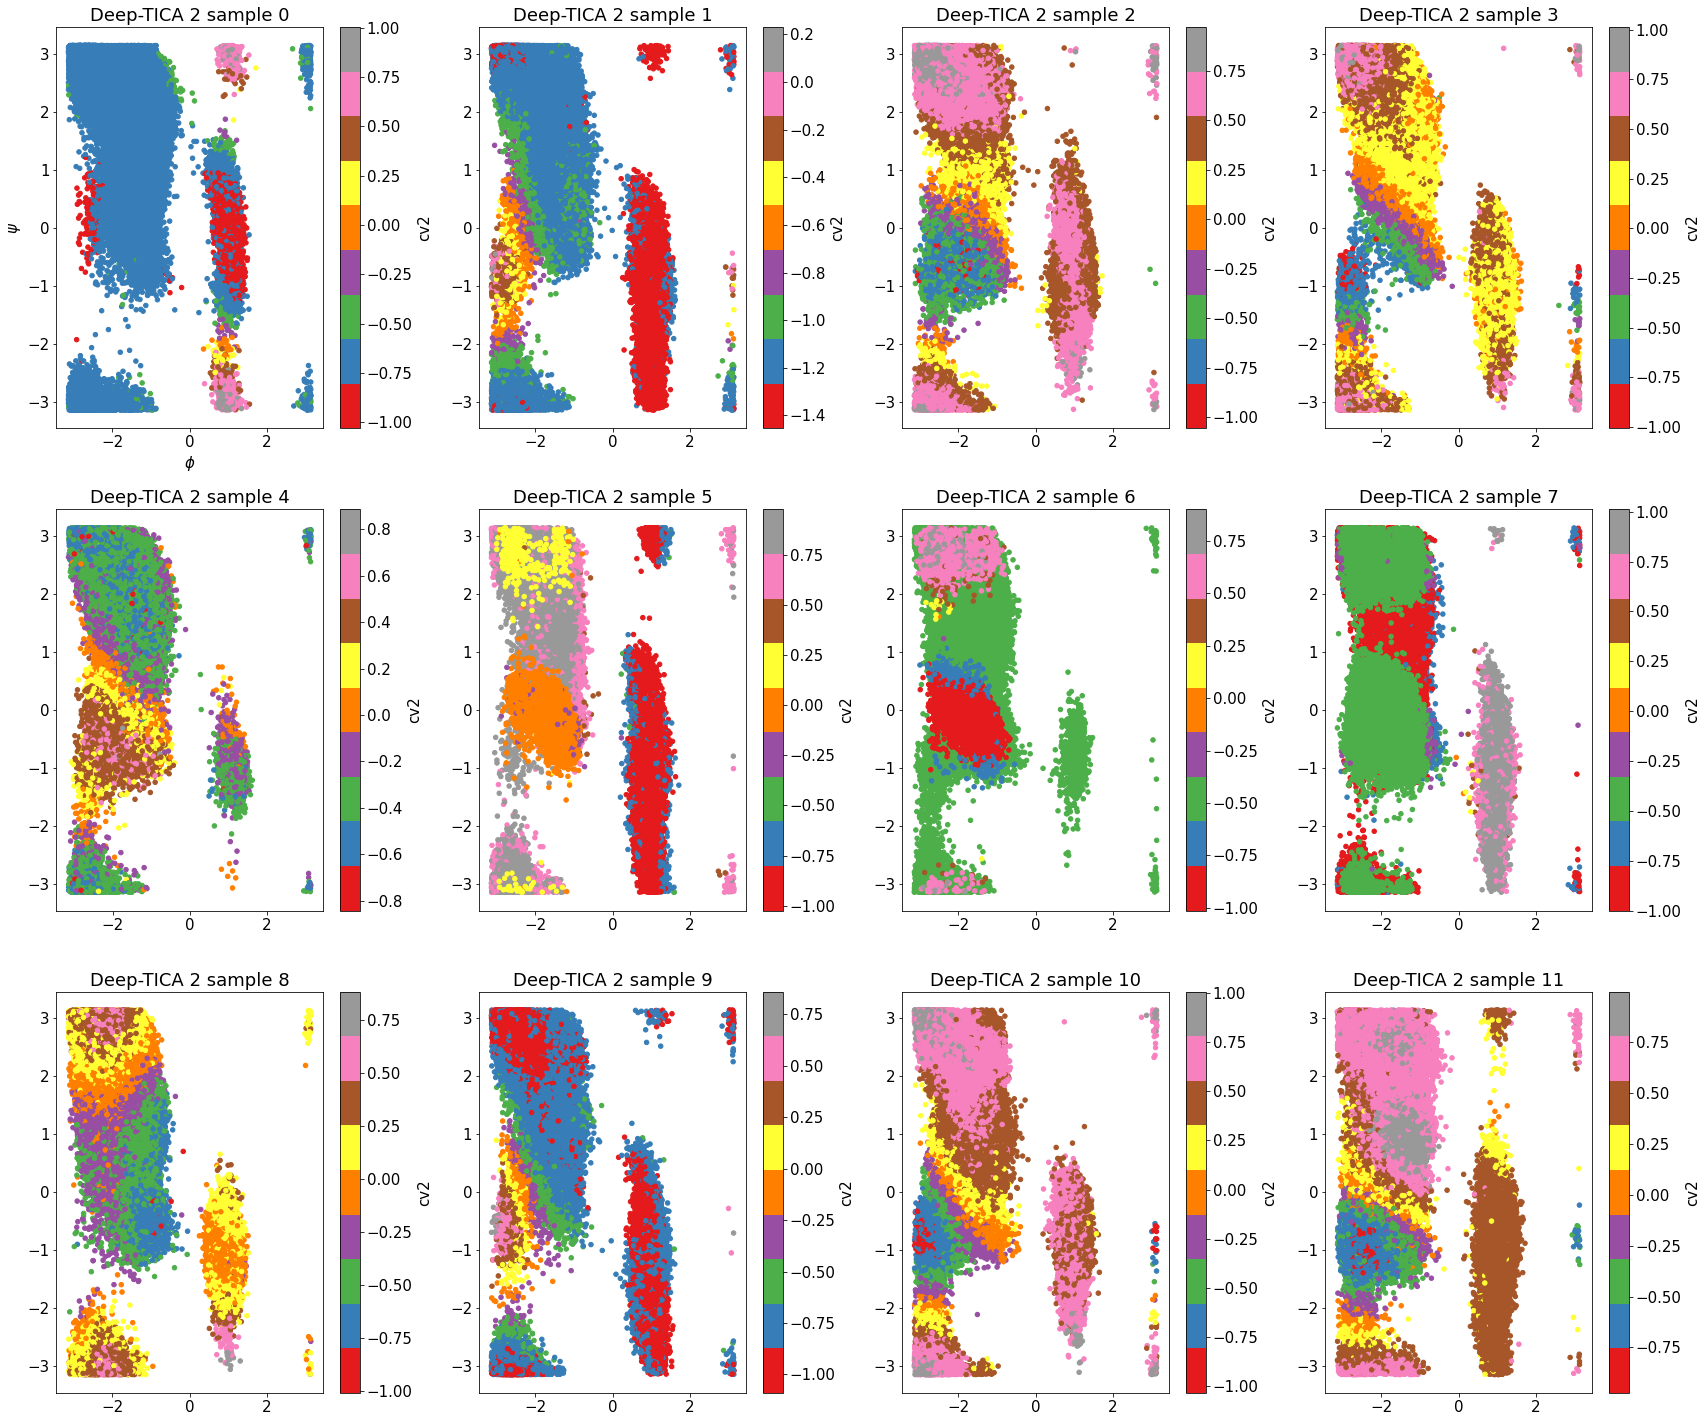

In [11]:
#-- cv2 --#
fig,axs = plt.subplots(3,4,figsize=(24,20))

for i,ax in enumerate(fig.axes):
    datas[i].plot.scatter(y="psi",x="phi",c="cv2",cmap="Set1",ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title('Deep-TICA 2 sample '+str(i))
axs[0][0].set_ylabel(r"$\psi$")
axs[0][0].set_xlabel(r"$\phi$")
plt.tight_layout()